In [5]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from math import log, sqrt
import pandas as pd
import numpy as np
import re
%matplotlib inline

# sample training set, 0 is good and 1 is bad sentiment
train = pd.read_csv("training.csv")
train['label'] = train['Label'].map({'Pos': 0, 'Neg': 1})
train.drop(['Label'], axis = 1, inplace = True)
train.head()

,message,label
0,Juncker is set to meet President Donald Trump ...,0
1,U.S. President Donald Trump said on Friday tha...,0
2,U.S. President Donald Trump spoke warmly of Me...,0
3,Treasury Secretary Steven Mnuchin tells CNBC t...,0
4,"'Kim Jong-un is making terrific progress,' Tru...",0


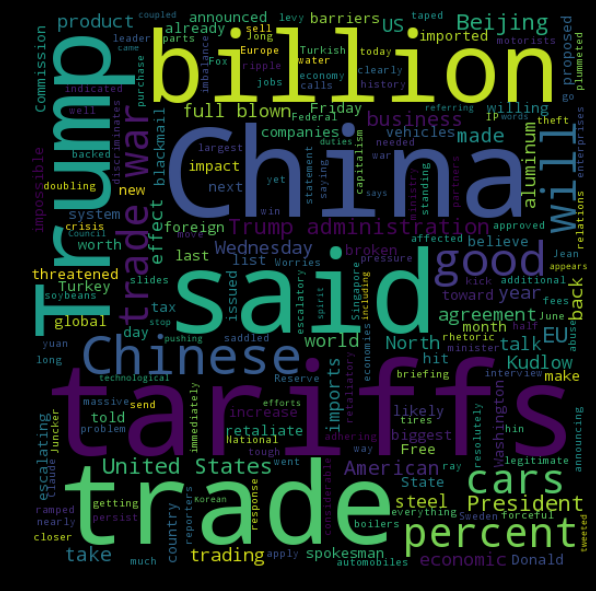

In [10]:
# wordcloud bad news
neg_words = ' '.join(list(train[train['label'] == 1]['message']))
neg_wc = WordCloud(width = 512,height = 512).generate(neg_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(neg_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

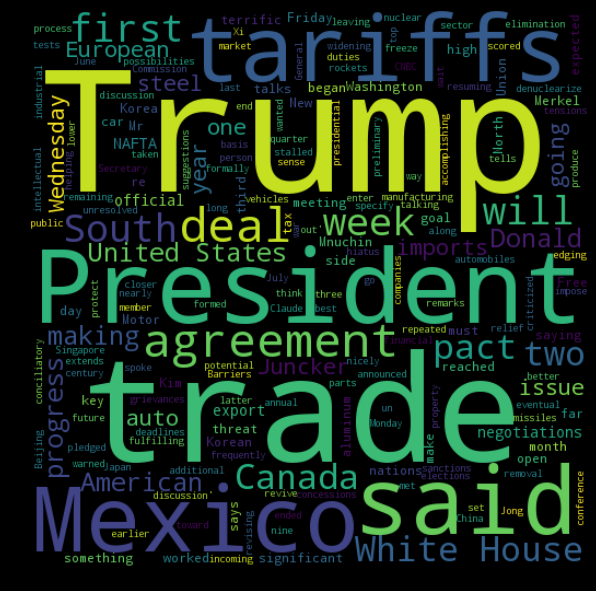

In [9]:
# wordcloud good news
pos_words = ' '.join(list(train[train['label'] == 0]['message']))
pos_wc = WordCloud(width = 512,height = 512).generate(pos_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(pos_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

In [7]:
def process_message(message, lower_case = True, stem = True, stop_words = True, gram = 2):
    if lower_case:
        message = message.lower()
    words = word_tokenize(message)
    words = [w for w in words if len(w) > 2]
    if gram > 1:
        w = []
        for i in range(len(words) - gram + 1):
            w += [' '.join(words[i:i + gram])]
        return w
    if stop_words:
        sw = stopwords.words('english')
        words = [word for word in words if word not in sw]
    if stem:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]   
    return words

In [6]:
class SpamClassifier(object):
    def __init__(self, trainData, method = 'tf-idf'):
        self.mails, self.labels = trainData['message'], trainData['label']
        self.method = method

    def train(self):
        self.calc_TF_and_IDF()
        if self.method == 'tf-idf':
            self.calc_TF_IDF()
        else:
            self.calc_prob()

    def calc_prob(self):
        self.prob_spam = dict()
        self.prob_ham = dict()
        for word in self.tf_spam:
            self.prob_spam[word] = (self.tf_spam[word] + 1) / (self.spam_words + \
                                                                len(list(self.tf_spam.keys())))
        for word in self.tf_ham:
            self.prob_ham[word] = (self.tf_ham[word] + 1) / (self.ham_words + \
                                                                len(list(self.tf_ham.keys())))
        self.prob_spam_mail, self.prob_ham_mail = self.spam_mails / self.total_mails, self.ham_mails / self.total_mails 


    def calc_TF_and_IDF(self):
        noOfMessages = self.mails.shape[0]
        self.spam_mails, self.ham_mails = self.labels.value_counts()[1], self.labels.value_counts()[0]
        self.total_mails = self.spam_mails + self.ham_mails
        self.spam_words = 0
        self.ham_words = 0
        self.tf_spam = dict()
        self.tf_ham = dict()
        self.idf_spam = dict()
        self.idf_ham = dict()
        for i in range(noOfMessages):
            message_processed = process_message(self.mails[i])
            count = list() #To keep track of whether the word has ocured in the message or not.
                           #For IDF
            for word in message_processed:
                if self.labels[i]:
                    self.tf_spam[word] = self.tf_spam.get(word, 0) + 1
                    self.spam_words += 1
                else:
                    self.tf_ham[word] = self.tf_ham.get(word, 0) + 1
                    self.ham_words += 1
                if word not in count:
                    count += [word]
            for word in count:
                if self.labels[i]:
                    self.idf_spam[word] = self.idf_spam.get(word, 0) + 1
                else:
                    self.idf_ham[word] = self.idf_ham.get(word, 0) + 1

    def calc_TF_IDF(self):
        self.prob_spam = dict()
        self.prob_ham = dict()
        self.sum_tf_idf_spam = 0
        self.sum_tf_idf_ham = 0
        for word in self.tf_spam:
            self.prob_spam[word] = (self.tf_spam[word]) * log((self.spam_mails + self.ham_mails) \
                                                          / (self.idf_spam[word] + self.idf_ham.get(word, 0)))
            self.sum_tf_idf_spam += self.prob_spam[word]
        for word in self.tf_spam:
            self.prob_spam[word] = (self.prob_spam[word] + 1) / (self.sum_tf_idf_spam + len(list(self.prob_spam.keys())))
            
        for word in self.tf_ham:
            self.prob_ham[word] = (self.tf_ham[word]) * log((self.spam_mails + self.ham_mails) \
                                                          / (self.idf_spam.get(word, 0) + self.idf_ham[word]))
            self.sum_tf_idf_ham += self.prob_ham[word]
        for word in self.tf_ham:
            self.prob_ham[word] = (self.prob_ham[word] + 1) / (self.sum_tf_idf_ham + len(list(self.prob_ham.keys())))
            
    
        self.prob_spam_mail, self.prob_ham_mail = self.spam_mails / self.total_mails, self.ham_mails / self.total_mails 
                    
    def classify(self, processed_message):
        pSpam, pHam = 0, 0
        for word in processed_message:                
            if word in self.prob_spam:
                pSpam += log(self.prob_spam[word])
            else:
                if self.method == 'tf-idf':
                    pSpam -= log(self.sum_tf_idf_spam + len(list(self.prob_spam.keys())))
                else:
                    pSpam -= log(self.spam_words + len(list(self.prob_spam.keys())))
            if word in self.prob_ham:
                pHam += log(self.prob_ham[word])
            else:
                if self.method == 'tf-idf':
                    pHam -= log(self.sum_tf_idf_ham + len(list(self.prob_ham.keys()))) 
                else:
                    pHam -= log(self.ham_words + len(list(self.prob_ham.keys())))
            pSpam += log(self.prob_spam_mail)
            pHam += log(self.prob_ham_mail)
        return pSpam
        # return pSpam >= pHam
    
    def predict(self, testData):
        result = dict()
        for (i, message) in enumerate(testData):
            processed_message = process_message(message)
            result[i] = self.classify(processed_message)
            # result[i] = int(self.classify(processed_message))
        return result

In [8]:
sc_tf_idf = SpamClassifier(train)
sc_tf_idf.train()
# preds_tf_idf = sc_tf_idf.predict(testData['message'])
# metrics(testData['label'], preds_tf_idf)
test = pd.read_csv("test.csv")
test.head()
sc_tf_idf.predict(test['message'])

{0: -327.835559988973,
 1: -152.93792853158217,
 2: -350.87310289188997,
 3: -277.71881017735154,
 4: -192.2574993273839,
 5: -229.40689279737327,
 6: -192.2574993273839,
 7: -355.42532102640206,
 8: -151.29720843223208,
 9: -318.39418062547503,
 10: -203.83471634345887,
 11: -235.0142830255449,
 12: -200.30476451400384}